# Chess Auto Encoder

- Use HalfKP

TODO:
- Fetch fens
- Convert to HalfKP
- Save to file

In [1]:
# refresh imports
%load_ext autoreload
%autoreload 2

import torch
import pandas as pd
import chess
from tqdm import tqdm
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

from utils import   get_FenBatchProvider, transform
from stockfish_explain.gen_concepts import create_custom_concepts

# set default plot size as large
plt.rcParams['figure.figsize'] = [20, 10]



# Create Dataset

## Fetch fens 

In [6]:
batch_size = 50
num_batch = 3000

FBP = get_FenBatchProvider(batch_size=batch_size)

def fetch_batch():
    fens = next(FBP)
    results = []
    for i, fen in enumerate(fens):
        d = {}
        d['fen'] = fen
        board = chess.Board(fen)
        pieces = dict(Counter([str(v) for v in board.piece_map().values()]))
        d = {**d, **pieces}

        results.append(d)
    return results


data = []
for i in tqdm(range(num_batch)):
    data = data  + fetch_batch()
print(f'Len data: {len(data)}')

df = pd.DataFrame(data).fillna(0)
del data
print(f'df shape: {df.shape}')

100%|██████████| 3000/3000 [00:11<00:00, 264.54it/s]


Len data: 150000
df shape: (150000, 13)


## Add concepts

In [7]:
print(df.shape)
# add concept_dict to df
for idx, row in tqdm(df.iterrows()):
    board = chess.Board(row['fen'])
    concept_dict = create_custom_concepts(board)
    for k, v in concept_dict.items():
        df.at[idx, k] = v   
print(df.shape)

columns_names = {
    'K': 'white_king',
    'k': 'black_king',
    'Q': 'white_queen',
    'q': 'black_queen',
    'R': 'white_rook',
    'r': 'black_rook',
    'B': 'white_bishop',
    'b': 'black_bishop',
    'N': 'white_knight',
    'n': 'black_knight',
    'P': 'white_pawn',
    'p': 'black_pawn',
}


df = df.rename(columns=columns_names)

(150000, 13)


150000it [05:07, 487.19it/s]

(150000, 29)


In [8]:
columns_names = {
    'K': 'white_king',
    'k': 'black_king',
    'Q': 'white_queen',
    'q': 'black_queen',
    'R': 'white_rook',
    'r': 'black_rook',
    'B': 'white_bishop',
    'b': 'black_bishop',
    'N': 'white_knight',
    'n': 'black_knight',
    'P': 'white_pawn',
    'p': 'black_pawn',
}


df = df.rename(columns=columns_names)

In [9]:
# store df in sqlite db for later use
import sqlite3
conn = sqlite3.connect('chess_auto_encoder.db')
df.to_sql('fen_concept_df', conn, if_exists='replace', index=True)
conn.close()

del df


## Convert to HalfKP

# Dataset

# Autoencoder


# Custom Autoencoder

In [4]:
import matplotlib.pyplot as plt
from model import DeepAutoencoder
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

batch_size = 200
train_loader = get_FenBatchProvider(batch_size=batch_size)
val_loader = get_FenBatchProvider(batch_size=batch_size)


# Instantiating the model and hyperparameters
model = DeepAutoencoder(input_size=641)
#criterion = torch.nn.MSELoss()
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 1000
max_iterations = 500
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model = model.cuda()

# List that will store the training loss
train_loss = []
  
# Dictionary that will store the
# different images and outputs for 
# various epochs
outputs = {}
  
  
# Training loop starts
for epoch in tqdm(range(num_epochs)):
        
    # Initializing variable for storing 
    # loss
    running_loss = 0
      
    it = 0
    # Iterating over the training dataset
    for batch in train_loader:

        if it == max_iterations:
            break
        it += 1
            
        # Loading image(s) and
        # reshaping it into a 1-d vector
        img = batch
        img = transform(img) 
        img = img.reshape(-1, model.input_size).cuda()
          
        # Generating output
        out = model(img)
          
        # Calculating loss
        loss = criterion(out, img.int())
          
        # Updating weights according
        # to the calculated loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
          
        # Incrementing loss
        running_loss += loss.item()
      
    # Averaging out loss over entire batch
    running_loss /= batch_size
    train_loss.append(running_loss)

    writer.add_scalar("Loss/train", running_loss, epoch)

    # save model every 100 epochs
    if epoch % 100 == 0:
        torch.save(model.state_dict(), f'./models/model_{epoch}.pt')
      
    # Storing useful images and
    # reconstructed outputs for the last batch
    outputs[epoch+1] = {'img': img, 'out': out}
  
  
writer.flush()
# Plotting the training loss
plt.plot(range(1,num_epochs+1),train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

# save model to disk
torch.save(model.state_dict(), 'model.pt')


 13%|█▎        | 126/1000 [34:44<4:00:57, 16.54s/it]


KeyboardInterrupt: 

In [1]:
a = 4

# Fetch activations from encoders

In [11]:
from scipy.sparse import csr_matrix, vstack
from tqdm import tqdm
import pandas as pd
import sqlite3
from small_model import DeepAutoencoder
from scipy.special import expit

# load model from disk

model = DeepAutoencoder(input_size = 641)
model.load_state_dict(torch.load('models/model_BCE_small_2_900.pt'))

# load df from sqlite db
conn = sqlite3.connect('chess_auto_encoder.db')
df = pd.read_sql_query('select * from fen_concept_df', conn)
conn.close()

activation = {}
def get_output_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def get_input_activation(name):
    def hook(model, input, output):
        activation['input_'+name] = input[0].detach()
    return hook

model.encoder_0.register_forward_hook(get_input_activation('encoder_0'))
model.encoder_0.register_forward_hook(get_output_activation('encoder_0'))
model.encoder_1.register_forward_hook(get_output_activation('encoder_1'))
model.encoder_2.register_forward_hook(get_output_activation('encoder_2'))
model.encoder_3.register_forward_hook(get_output_activation('encoder_3'))
model.decoder_0.register_forward_hook(get_output_activation('decoder_0'))
model.decoder_1.register_forward_hook(get_output_activation('decoder_1'))
model.decoder_2.register_forward_hook(get_output_activation('decoder_2'))
model.decoder_3.register_forward_hook(get_output_activation('decoder_3'))

model.cuda()

activation_list = []

for idx, row in tqdm(df.iterrows()):

    data = transform([row['fen']]).cuda()
    output = model(data)

    activations_ = {'index': idx}
    for k, v in activation.items():
        values = v.cpu().numpy()[0]
        if 0:
            if k in ['input_encoder_0',]:
                # convert values to csr matrix with boolean values
                values = csr_matrix(values, dtype=bool)
            elif k in ['decoder_3']:
                # convert values to csr matrix with boolean values
                values = csr_matrix(values > 0, dtype=bool)
            else:
                # convert values to numpy float16
                values = values.astype(np.float16)
        if k in ['decoder_3']:
            values = expit(values)
        else:
            values = values.astype(np.float16)
        
        activations_[k] = values


    # copy activation and add to activation_list
    activation_list.append(activations_.copy())

df_activations = pd.DataFrame(activation_list)

150000it [01:58, 1268.23it/s]


In [12]:
df_activations.head()

,index,input_encoder_0,encoder_0,encoder_1,encoder_2,encoder_3,decoder_0,decoder_1,decoder_2,decoder_3
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-10.62, -5.75, -3.062, -6.723, -5.65, -5.43, ...","[-1.029, -3.568, -1.439, -4.055, 26.86, 7.734,...","[-19.36, 19.89, -12.59, 17.81, 6.082, 16.92, -...","[-3.045, -2.584, 5.285, -8.445, -0.35, -11.35,...","[2.885, -5.77, 4.074, 2.45, 4.445, 4.945, 3.71...","[-4.11, -4.01, -9.56, -5.633, -3.3, -5.484, 1....","[-7.844, -27.34, -18.05, -14.06, -3.691, -26.8...","[2.7892106e-19, 7.0571576e-19, 1.2430046e-18, ..."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-9.69, -3.889, -2.314, -11.11, -5.543, -7.86,...","[-0.9097, -2.77, -1.427, -4.125, 14.98, 9.13, ...","[-16.84, 23.61, -9.71, 18.0, 13.78, 6.305, -14...","[-5.734, 3.725, 0.2764, -20.28, -0.6016, -1.99...","[7.094, -6.094, 3.576, 2.467, 5.016, 4.914, 1....","[-5.668, -4.438, -12.01, 1.322, -3.82, -2.512,...","[1.473, -27.64, -26.95, -2.053, -19.61, -18.02...","[9.705943e-17, 2.5982082e-16, 1.9473937e-16, 1..."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-8.85, -3.266, -3.812, -6.223, -4.887, -4.82,...","[-1.435, -3.79, -1.559, -4.72, 4.36, 6.207, 6....","[-13.2, 11.91, -11.055, 14.35, 9.41, 7.137, -1...","[2.955, -1.294, 1.451, -11.77, 5.09, 7.79, 0.2...","[5.316, -5.457, 3.969, -1.205, 6.37, 6.285, 2....","[-3.564, -2.336, -7.207, 1.849, -2.896, -4.914...","[-1.49, -17.86, -23.73, -0.8022, -14.08, -14.9...","[6.0409827e-19, 1.8678441e-18, 7.037133e-18, 2..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-6.91, -4.88, -2.367, -0.2732, -4.42, -3.066,...","[-0.885, -3.355, -1.445, -4.67, 15.14, 4.26, 2...","[-15.125, 11.414, -10.45, 5.73, 7.266, 5.5, -1...","[-1.523, 4.94, 4.1, -3.512, -1.172, 2.006, 2.6...","[4.29, -5.996, 3.129, -0.259, 1.403, 3.965, 3....","[-2.64, -3.31, -5.45, -2.059, -1.716, 2.646, 1...","[-0.04584, -18.7, -10.6, -9.12, -18.08, -17.31...","[2.6603533e-14, 3.0052692e-14, 3.8371904e-14, ..."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.055, -3.256, -1.651, -1.081, -3.754, -3.21...","[-1.118, -3.32, -1.644, -4.47, 16.08, 1.911, 2...","[-13.02, 14.586, -7.2, 10.24, 6.707, 5.844, -1...","[0.6514, -0.9937, 0.4114, -7.793, -0.2472, 0.6...","[3.53, -5.863, 2.125, -0.2224, 2.746, 2.463, 2...","[-2.969, -3.11, -4.92, 0.8374, -3.285, 1.596, ...","[0.2783, -23.02, -15.875, -3.645, -17.19, -12....","[6.7443645e-10, 1.235508e-09, 8.2557905e-10, 5..."


In [18]:
idx = 0
input = df_activations.iloc[idx]['input_encoder_0']
output = df_activations.iloc[idx]['decoder_3']

print(input)

print(output)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [21]:
from scipy.special import expit

expit(output).min()

0.010052369

In [5]:
df_activations['decoder_3']

0         
1         
2         
3         
4         
        ..
49995     
49996     
49997     
49998     
49999     
Name: decoder_3, Length: 50000, dtype: object

In [4]:
df.columns.tolist()

['index',
 'fen',
 'black_rook',
 'black_king',
 'white_pawn',
 'white_rook',
 'black_pawn',
 'white_king',
 'black_queen',
 'black_knight',
 'black_bishop',
 'white_queen',
 'white_knight',
 'white_bishop',
 'white_bishop_pair',
 'black_bishop_pair',
 'white_knight_pair',
 'black_knight_pair',
 'white_double_pawn',
 'black_double_pawn',
 'white_isolated_pawns',
 'black_isolated_pawns',
 'white_connected_rooks',
 'black_connected_rooks',
 'white_has_control_of_open_file',
 'black_has_control_of_open_file',
 'has_contested_open_file',
 'is_forking',
 'can_fork',
 'can_check']

# Concept Model

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (
    ElasticNet,
    LogisticRegression,
    Ridge,
    RidgeClassifier,
    SGDRegressor,
    LinearRegression,
)
from sklearn.svm import SVC
from lightgbm import LGBMClassifier, LGBMRegressor

from imblearn.under_sampling import RandomUnderSampler
# import confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


def classification_cost(y_test, y_pred):
    y_test = np.array(y_test).astype(int)
    y_pred = np.array(y_pred).astype(int)
    residuals = 1 - np.abs(y_pred - y_test)
    return np.mean(residuals) * 2 - 1

test_size = 0.33
input_name = 'encoder_3'
target_name = 'has_contested_open_file'

concept_model = LGBMClassifier()
#concept_model = LogisticRegression()
metric = classification_cost

verbose = False

undersample = RandomUnderSampler(
    sampling_strategy="majority"
)

concept_models = [RidgeClassifier(), LGBMClassifier()]
input_names = ['input_encoder_0', 'encoder_0', 'encoder_1', 'encoder_2', 'encoder_3', 'decoder_0', 'decoder_1', 'decoder_2','decoder_3']
target_names = ['has_contested_open_file','white_double_pawn', 'white_queen']


results = []
for concept_model in concept_models:
    for input_name in input_names:
        for target_name in target_names:

            model_name = f"{concept_model.__class__.__name__}"

            X = df_activations[input_name].tolist()
            y = df[target_name].tolist()
            print(f"X: {input_name}, y: {target_name}, model_name: .{model_name}")

            # if X is scipy.sparse.csr_matrix, vstack it 
            if isinstance(X[0], csr_matrix):
                X = vstack(X).astype(np.float32)
                size = X.shape[1]
            else:
                size = len(X[0])

            # change type of y to int
            y = np.array(y).astype(int)

            if target_name == 'white_queen':
                # is y larger than 0
                y = y > 0

            # fit and apply the transform
            X, y = undersample.fit_resample(X, y)


            # split into train and test sets 
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=42, stratify=y
            )



            concept_model.fit(X_train, list(y_train))
            y_pred = concept_model.predict(X_test)

            score = metric(y_test, y_pred)

            # calculate confusion matrix
            matrix = confusion_matrix(y_test, y_pred)

            if verbose:
                print(f'Target value counts: {pd.Series(y_train).value_counts()}')
                print(f'Target value counts: {pd.Series(y_test).value_counts()}')
                print(f'input shape: {size}')
                print(matrix)
                print(score)

            results_ = {'model_name': model_name,
                        'input_name': input_name, 
                        'target_name': target_name,
                        'score': score, 
                        'size': size}
            results.append(results_)

df_results = pd.DataFrame(results)
df_results

X: input_encoder_0, y: has_contested_open_file, model_name: .RidgeClassifier
X: input_encoder_0, y: white_double_pawn, model_name: .RidgeClassifier
X: input_encoder_0, y: white_queen, model_name: .RidgeClassifier
X: encoder_0, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_0, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_0, y: white_queen, model_name: .RidgeClassifier
X: encoder_1, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_1, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_1, y: white_queen, model_name: .RidgeClassifier
X: encoder_2, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_2, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_2, y: white_queen, model_name: .RidgeClassifier
X: encoder_3, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_3, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_3, y: white_queen, model_name: .RidgeClassifier
X: deco

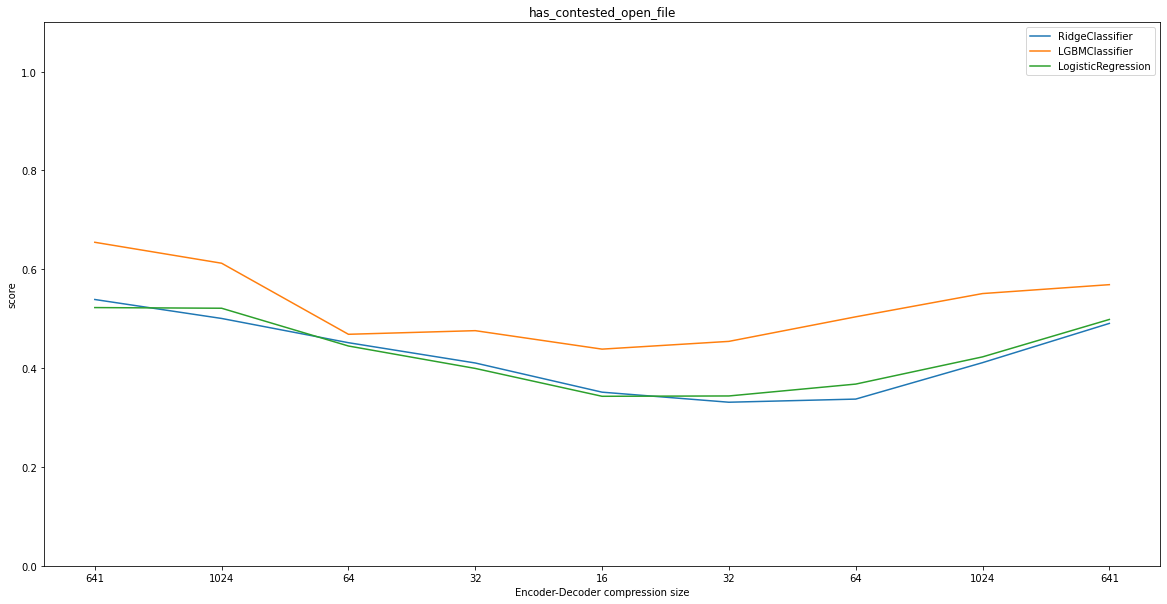

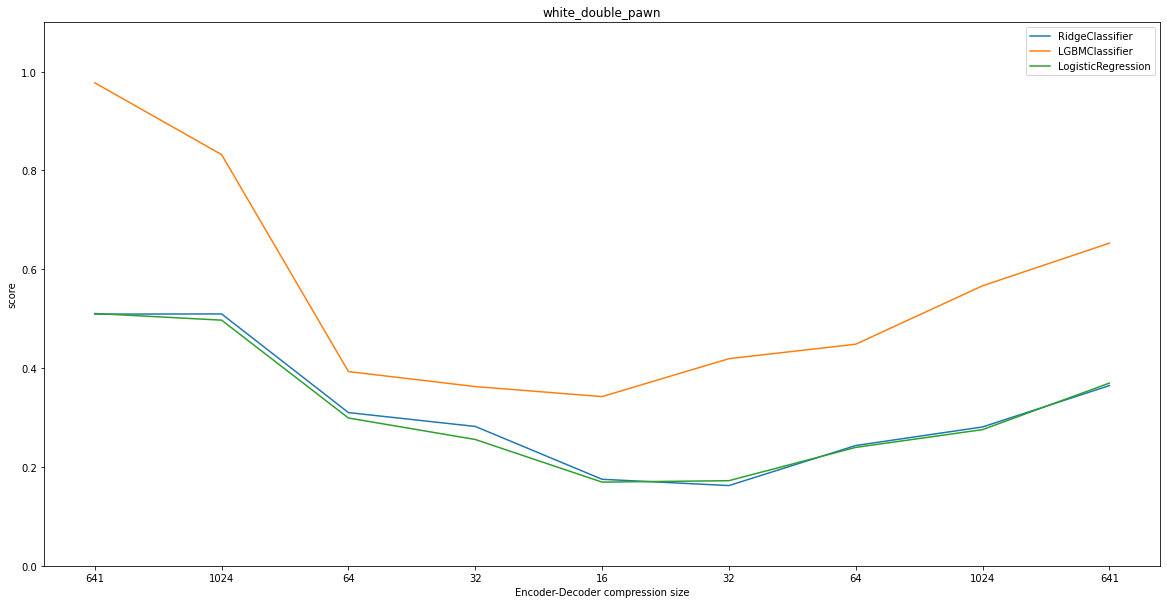

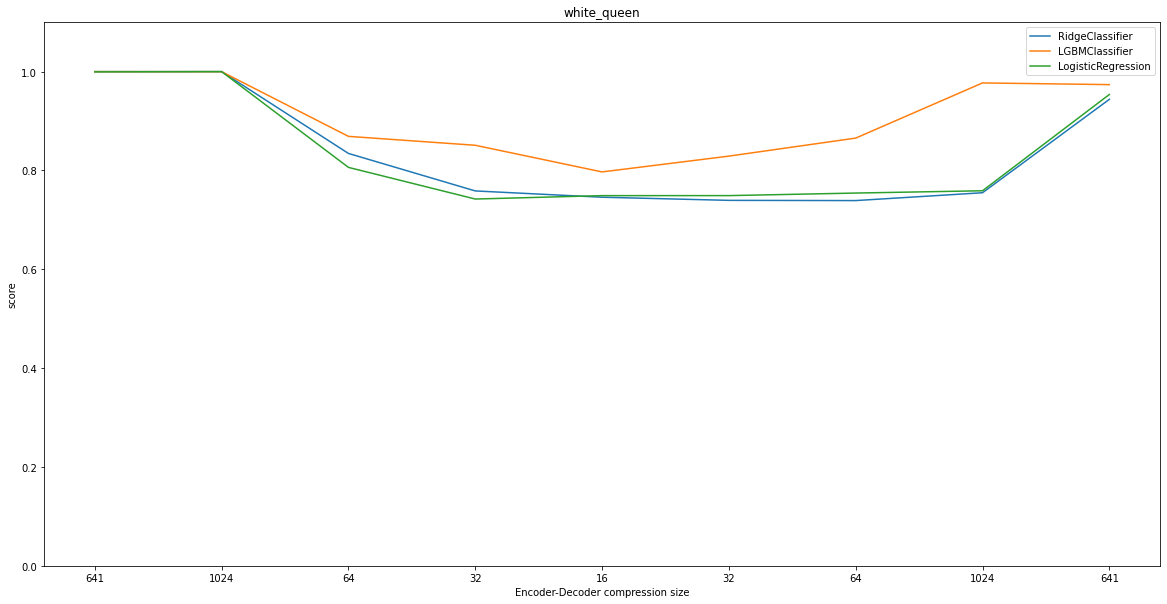

In [15]:
for target_name in df_results.target_name.unique():
    df_results_ = df_results[df_results.target_name == target_name]
    for model_name  in df_results_.model_name.unique():
        # plot scores
        plt.plot(range(len(df_results_[df_results_.model_name == model_name])), df_results_[df_results_.model_name == model_name].score, label=model_name)

    # set x ticks as size   
    plt.xticks(range(len(df_results_[df_results_.model_name == model_name])), df_results_[df_results_.model_name == model_name]['size'].astype(str))
    plt.title(target_name)
    plt.ylabel('score')
    plt.xlabel('Encoder-Decoder compression size')
    plt.ylim(0,1.1)
    plt.legend()
    plt.show()

# 

In [9]:
torch.sigmoid(torch.tensor(00))

tensor(0.5000)